In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
%matplotlib inline

# The model

The model is fairly simple. It consists of a logistic growth eqn as

$$
y_t = \frac{L}{1 + \exp(-k(t - t_0) + \sigma \cdot \eta_t)}
$$

where $\eta_t$ is an autoregressive noise, ie

$$
\eta_t = \rho \cdot \eta_{t-1} + \epsilon_t,\quad \epsilon_t \sim N(0, 1)
$$

In [2]:
def ornstein_uhlenbeck_noise(T: int, sigma: float, rho: float):
    etas = np.random.normal(0, 1, 5 * T) * sigma  # white noise
    x = np.zeros(5 * T)
    for t in range(1, 5 * T):
        x[t] = rho * x[t - 1] + etas[t]
    return x[-T:]


def logistic_curve(T: int, t0: float, sigma: float, rho: float, L: float, k: float):
    # L / (1 + exp(-k * (t- t0) + noise))
    x = np.zeros(T)
    noise = ornstein_uhlenbeck_noise(T, sigma, rho)
    for t in range(T):
        x[t] = L / (1 + np.exp(-k * (t - t0) + noise[t]))
    return x

# Bayesian model

Below the code to run the model calibration.

What I do is I split the data in two parts. Here (just for fun) the split is 60% for train and the rest for test. 

The function below defines the model and calibrates it.

In [8]:
def generate_model(data: np.ndarray, split_factor=0.6):
    T = len(data)
    # Splitting the data
    split_point = int(T * split_factor)
    train_data = data[:split_point]
    test_data = data[split_point:]

    # Corresponding time points for train and test data
    t_train = list(range(split_point))
    t_test = list(range(split_point, T))

    # Create the model using only training data
    with pm.Model() as LogisticModel:
        # Add coordinates for observed dimensions
        LogisticModel.add_coord("train_id", t_train, mutable=True)

        # Define priors and logistic model for the training data
        L = pm.Normal("L", mu=10, sigma=5)
        k = pm.HalfNormal("k", sigma=2)
        t0 = pm.Normal("t0", mu=50, sigma=10)
        rho = pm.Uniform("rho", lower=-1, upper=1)
        sigma = pm.HalfNormal("sigma", sigma=1)

        noise_train = pm.AR("noise", rho=rho, dims="train_id")
        logistic_train = L / (
            1 + pm.math.exp(-k * (np.arange(split_point) - t0) + sigma * noise_train)
        )

        # Likelihood for training data
        Y_obs = pm.Normal("Y_obs", mu=logistic_train, sigma=0.1, observed=train_data)

        # Sample from the posterior
        idata = pm.sample(2000, target_accept=0.95)
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, LogisticModel

# Comparing

Below, everything is a bit rudimentary. I'm sure pymc has built in ways to do this better (I have done it with pure AR1 stuff, but I am not sure of how to do it with this custom model).


The idea is that the model is calibrated on the train data only. This means that it learns the distribution of the $\eta_t$ variables given the data. When we train, we need to generate noise with the noise at time $T_{\text{train}}$ as an initial condition. 

In [9]:
def generate_noise_sample(idata, split_point=0.6, T=100):
    # Flatten the chains and draws into a single dimension for rho and sigma
    rho_samples = idata.posterior["rho"].values.reshape(-1)
    sigma_samples = idata.posterior["sigma"].values.reshape(-1)
    last_noise_samples = idata.posterior["noise"].values[:, :, -1].reshape(-1)

    # Total number of samples (flattened from chains and draws)
    num_samples = rho_samples.shape[0]

    # Time points for train and test data
    t_train = np.arange(int(T * split_point))
    t_test = np.arange(int(T * split_point), T)

    # Number of test points
    n_test = len(t_test)

    # Preparing array to hold test noise for all samples
    test_noise_samples = np.zeros((num_samples, n_test))

    # Generating test noise for each flattened sample
    for idx in range(num_samples):
        # Initialize the first value of test noise using the last value of train noise
        test_noise_samples[idx, 0] = rho_samples[idx] * last_noise_samples[
            idx
        ] + np.random.normal(0, 1)

        # Generate AR noise for the rest of the test set
        for i in range(1, n_test):
            test_noise_samples[idx, i] = rho_samples[idx] * test_noise_samples[
                idx, i - 1
            ] + np.random.normal(0, 1)

    # Combining train and test noise for each sample path
    full_noise_samples = np.concatenate(
        [idata.posterior["noise"].values.reshape(num_samples, -1), test_noise_samples],
        axis=1,
    )
    return full_noise_samples


def generate_logistic_curve_samples(idata, T=100):
    full_noise_samples = generate_noise_sample(idata)
    # Extracting other logistic parameters from the posterior
    L_samples = idata.posterior["L"].values.flatten()
    k_samples = idata.posterior["k"].values.flatten()
    t0_samples = idata.posterior["t0"].values.flatten()
    sigma_samples = idata.posterior["sigma"].values.flatten()

    num_samples = L_samples.shape[0]

    # Time points for plotting
    t_points = np.arange(T)

    # Generate logistic growth curves for each sample
    def logistic_curve_with_noise(t, L, k, t0, sigma, noise):
        return L / (1 + np.exp(-k * (t - t0) + sigma * noise))

    # Preparing an array to hold all generated series
    all_generated_series = np.zeros_like(full_noise_samples)

    # Calculate the logistic curve for each sample
    for idx in range(num_samples):
        all_generated_series[idx] = logistic_curve_with_noise(
            t_points,
            L_samples[idx],
            k_samples[idx],
            t0_samples[idx],
            sigma_samples[idx],
            full_noise_samples[idx],
        )
    return all_generated_series

# Plotting

This just does plots.

In [10]:
def create_plot(ax, data, samples, T=100, split_factor=0.6):

    # Splitting the data
    split_point = int(T * split_factor)
    train_data = data[:split_point]
    test_data = data[split_point:]

    t_train = list(range(split_point))
    t_test = list(range(split_point, T))

    # Plotting the training data
    ax.plot(t_train, train_data, "o", label="Training data", color="tab:blue")

    # Plotting the test data
    ax.plot(t_test, test_data, "o", label="Test data", color="tab:green")

    t_points = np.arange(T)

    # Plotting the mean of the generated series
    ax.plot(
        t_points,
        samples.mean(axis=0),
        label="Mean of generated series",
        color="black",
    )

    # # Plotting the 95% credible interval
    # for series in all_generated_series:
    #     ax.plot(t_points, series, color="tab:gray", alpha=0.01)

    bottom_5perc = np.percentile(samples, 5, axis=0)
    top_5perc = np.percentile(samples, 95, axis=0)

    ax.fill_between(
        t_points, bottom_5perc, top_5perc, color="tab:red", alpha=0.3, label="95% CI"
    )

    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

In [13]:
%%time 
t0 = 70
T = 100
sigma = 0.2
rho = 0.1
L = 10
k = 0.06

data = logistic_curve(T, t0, sigma, rho, L, k)

idata, model = generate_model(data, split_factor=0.8)

samples = generate_logistic_curve_samples(idata=idata)

/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/pymc/model/core.py:999: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/pymc/distributions/timeseries.py:621: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, k, t0, rho, sigma, noise]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Y_obs]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: operands could not be broadcast together with shapes (100,) (120,) 

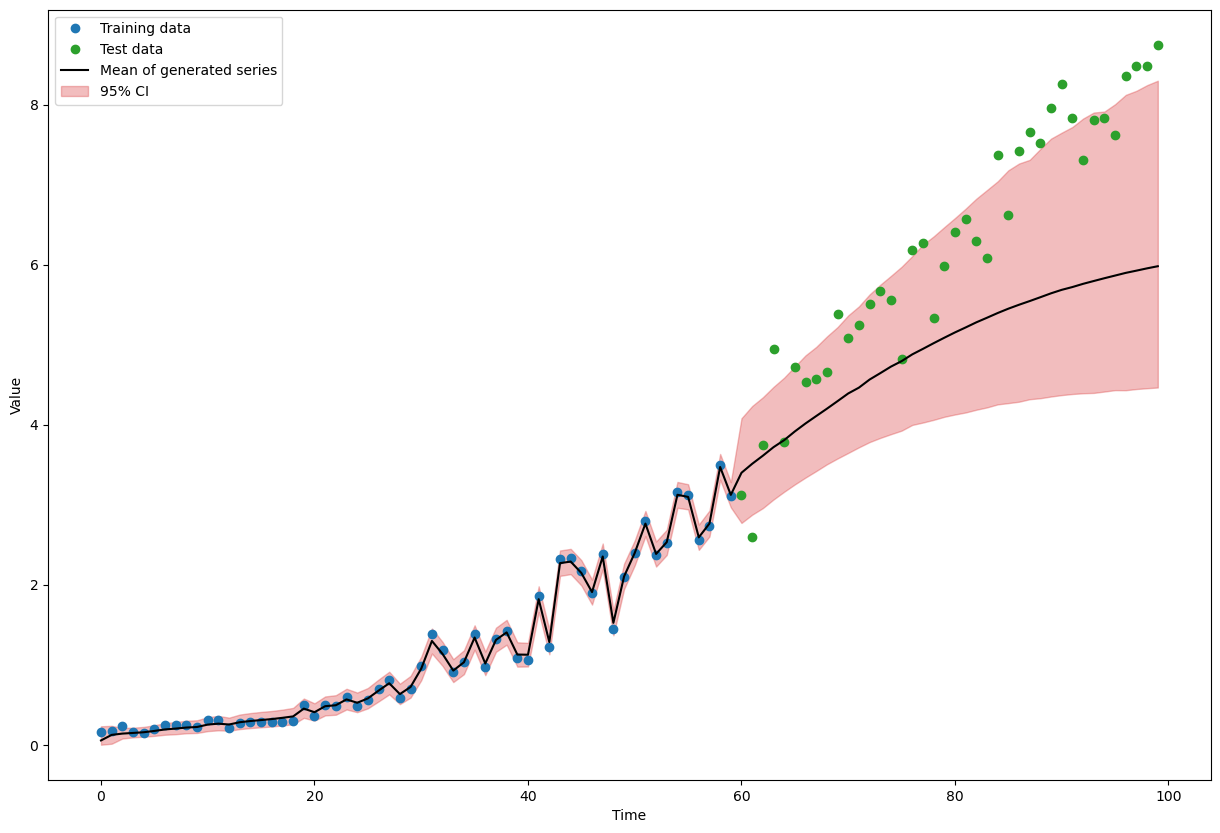

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
create_plot(ax, data, samples)

ax.legend()

Sometimes the plot above looks pretty shitty, but that's because of the 60% split with the parameters I chose (this is deliberate, you will see that t0=70 means that the inflection point is after the train data).

In [8]:
# print real values
print(f"t0: {t0}, L: {L}, k: {k}, sigma: {sigma}, rho: {rho}")

t0: 70, L: 10, k: 0.06, sigma: 0.2, rho: 0.1


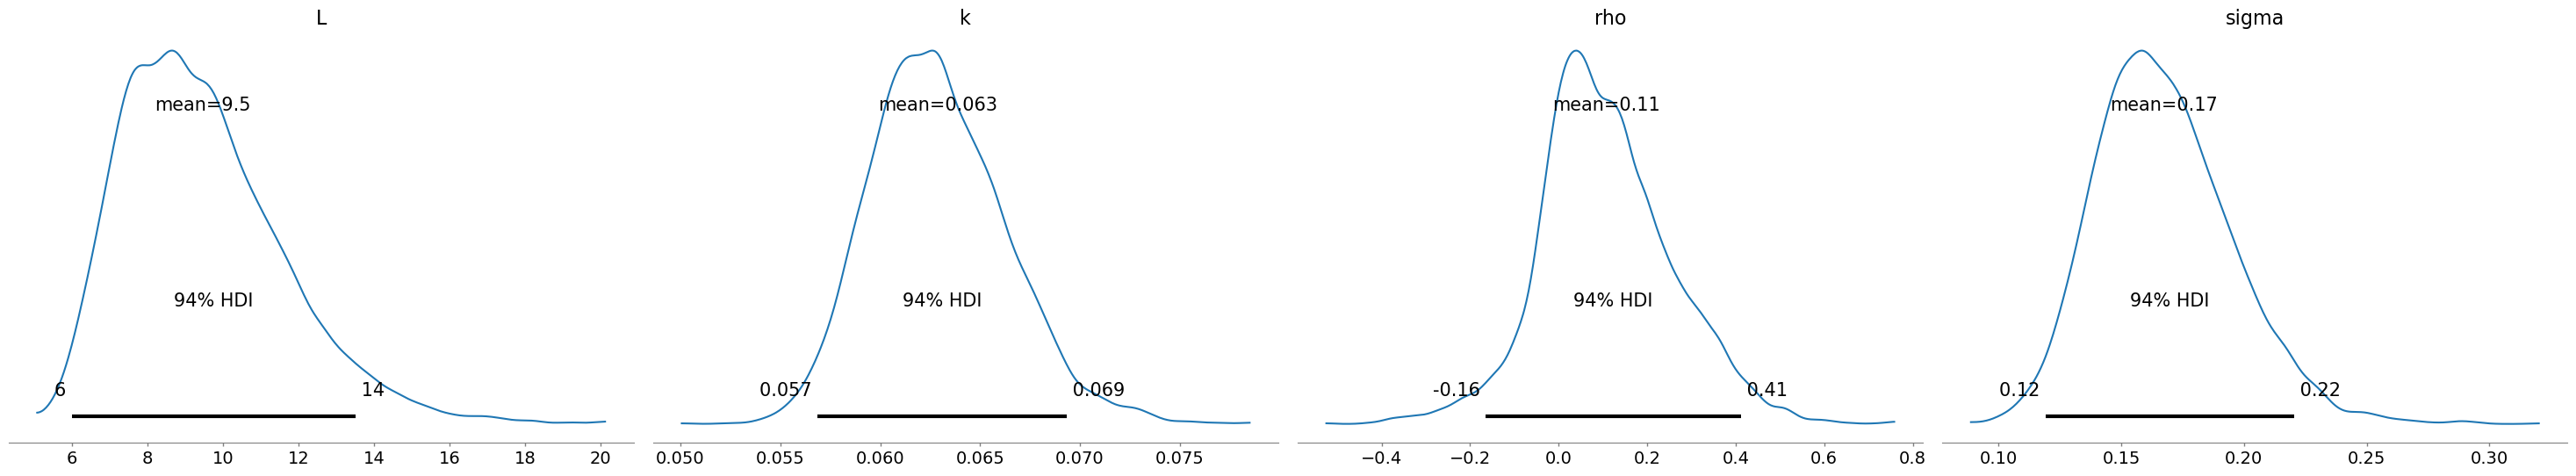

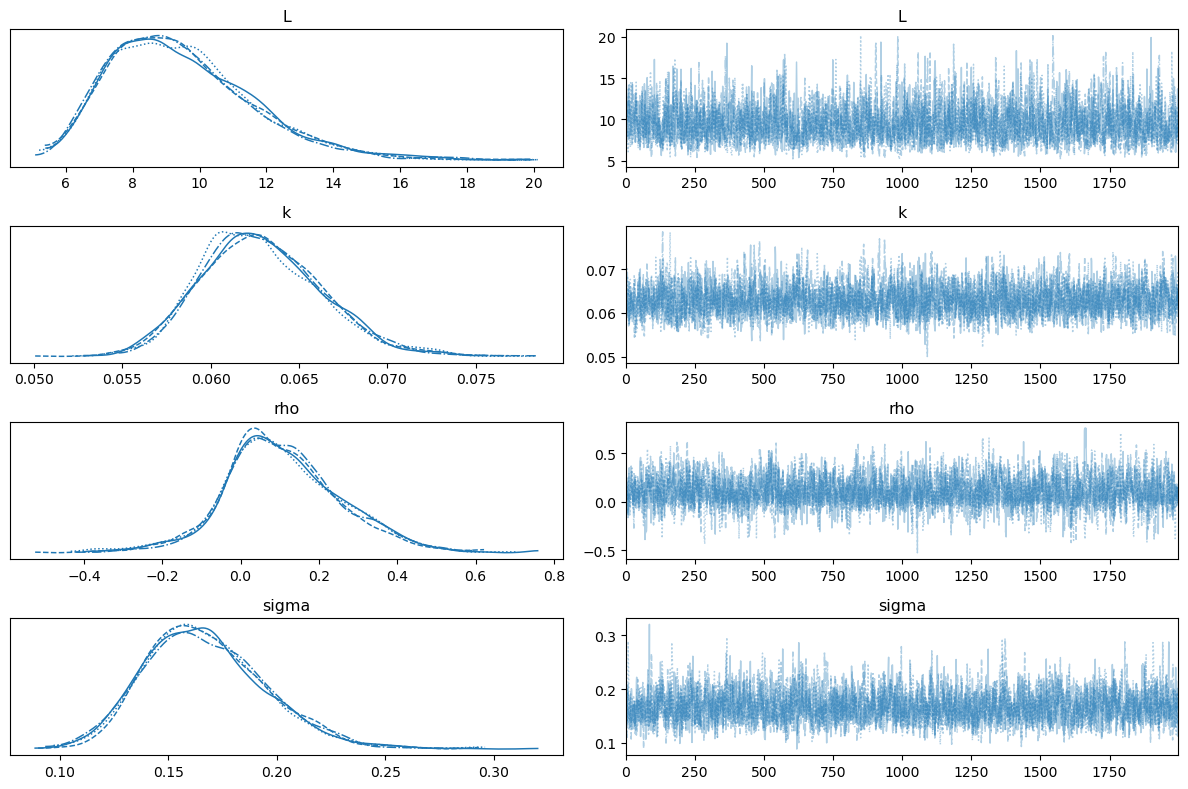

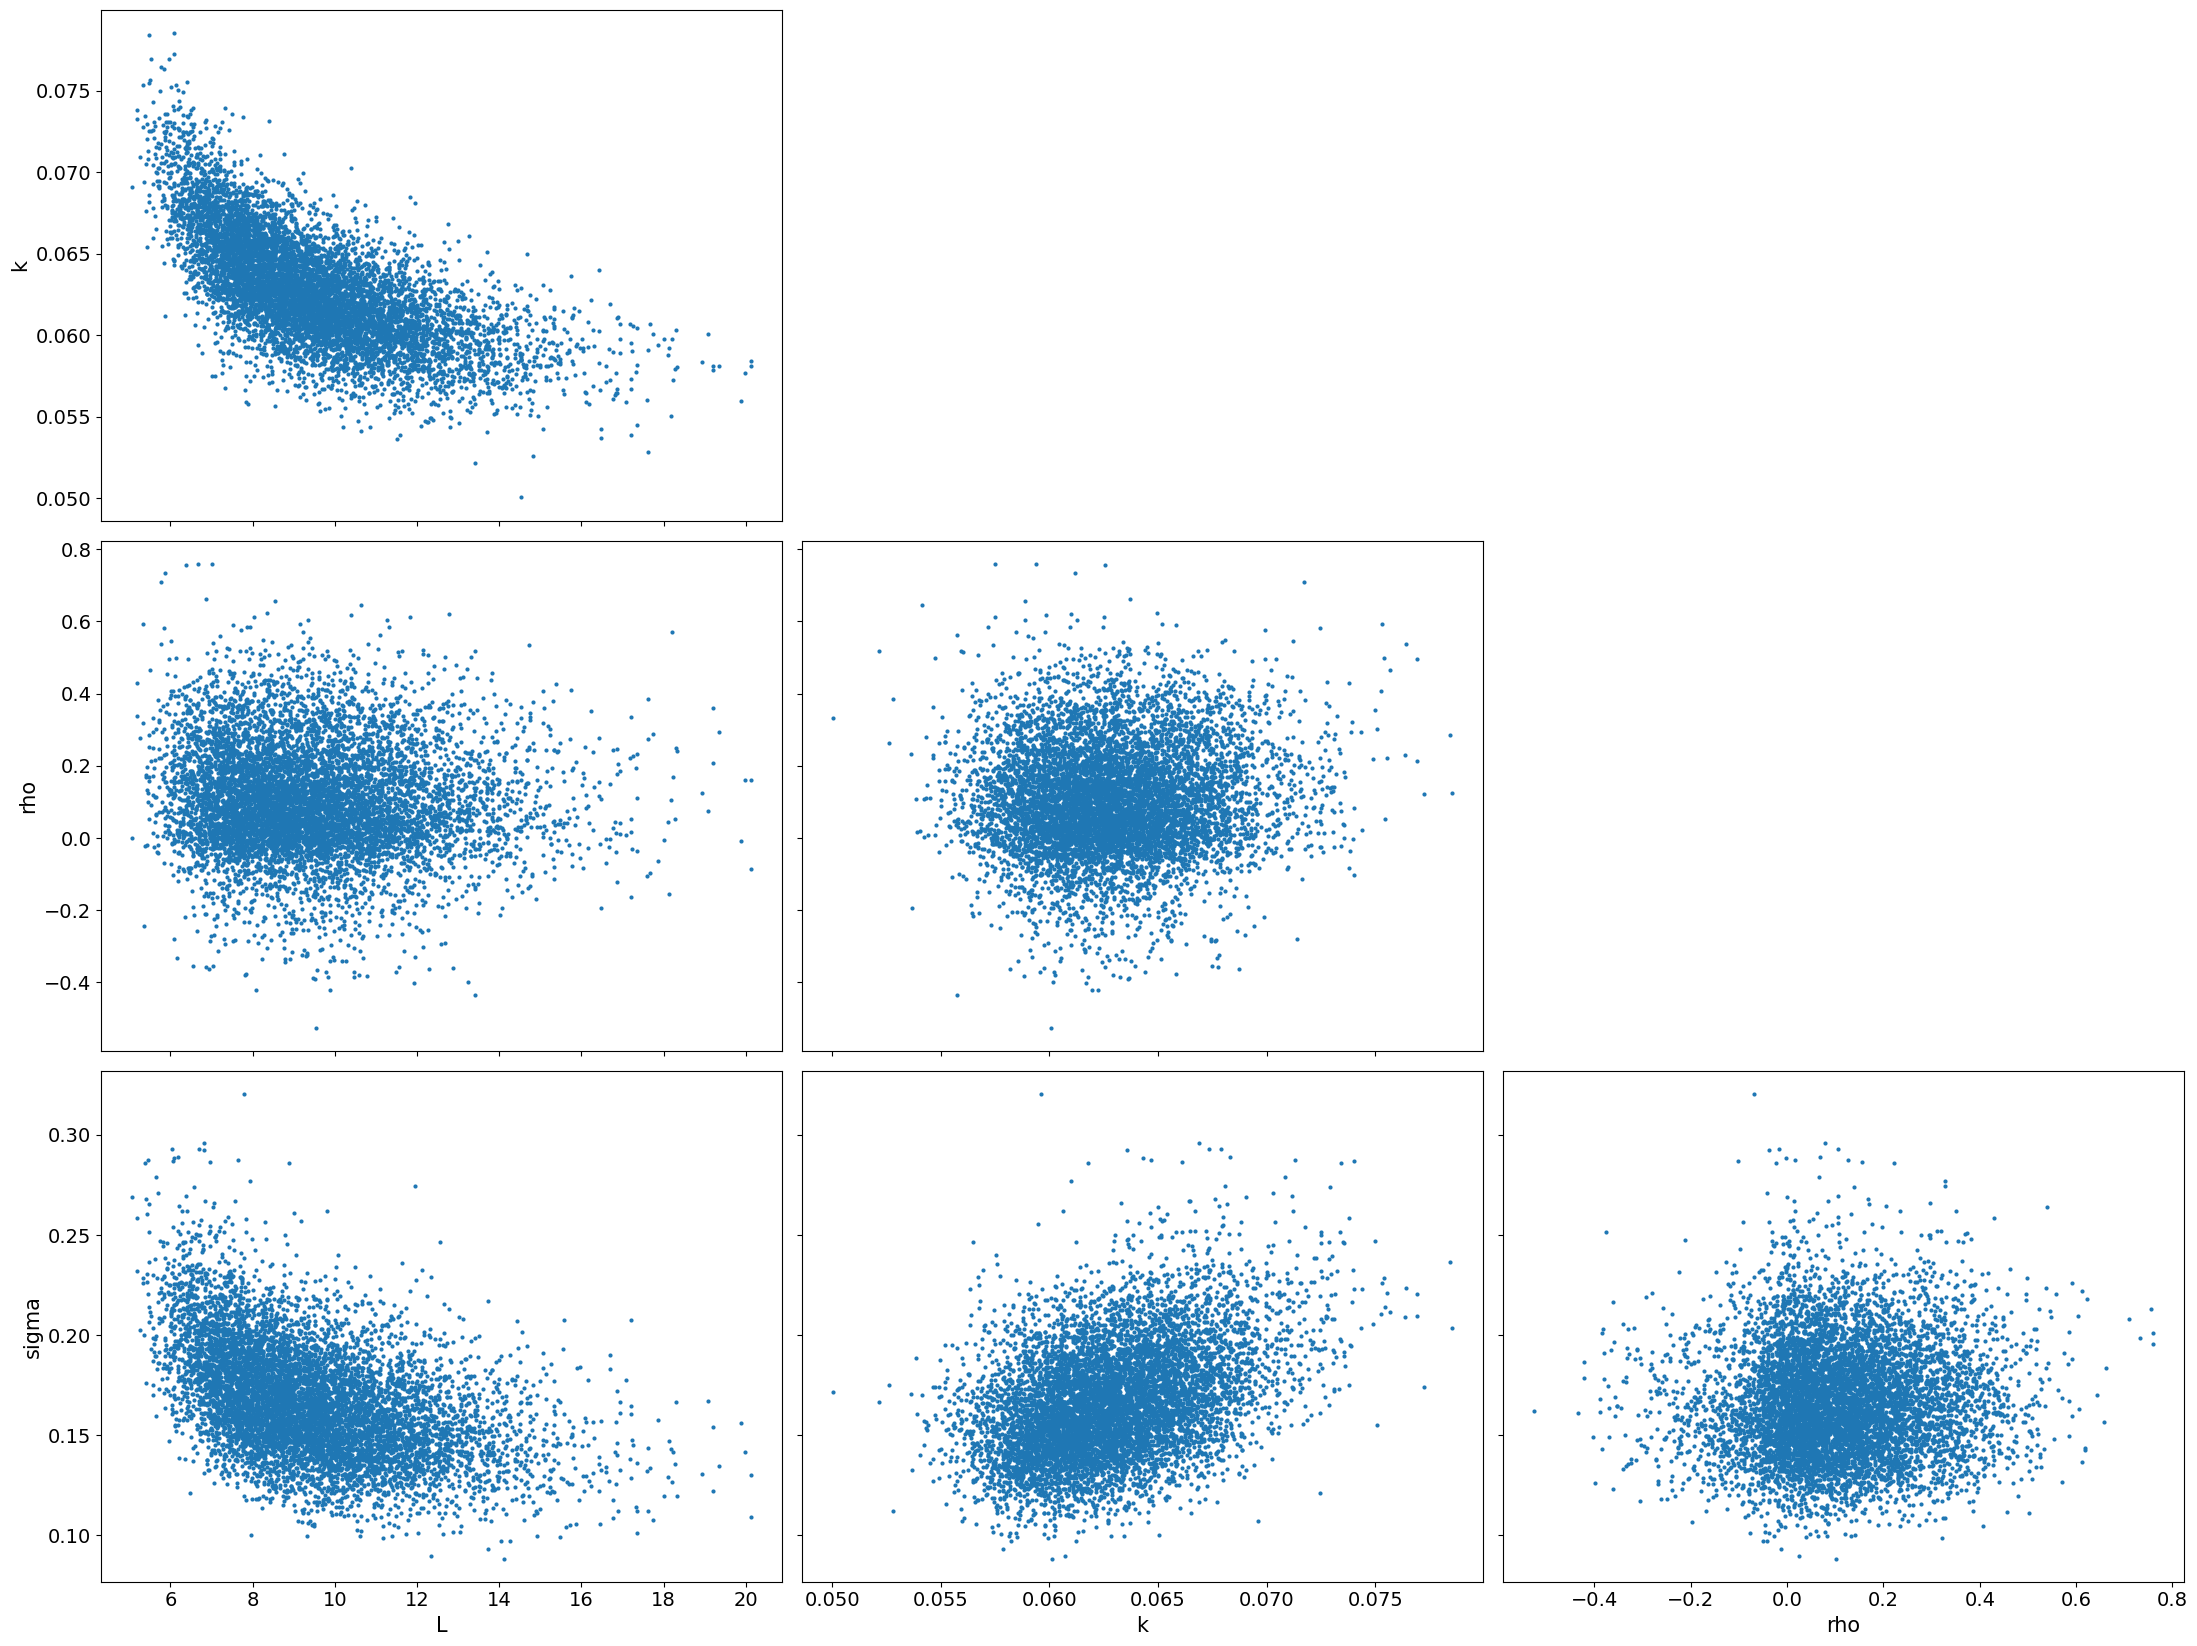

In [11]:
# plot inference data

# Plotting posterior distributions
az.plot_posterior(idata, var_names=["L", "k", "rho", "sigma"])
plt.tight_layout()
# Generating a trace plot
az.plot_trace(idata, var_names=["L", "k", "rho", "sigma"])
plt.tight_layout()
# Creating a pair plot
az.plot_pair(idata, var_names=["L", "k", "rho", "sigma"])
plt.tight_layout()
# Model diagnostics
az.summary(idata, var_names=["L", "k", "rho", "sigma"])
plt.tight_layout()